In [3]:
# EDA

# TODO: table of contents?
# Also document the single steps and conclusions drawn 
# ALSO REMOVE UNUSED COLS/TABLES
# move the imports up
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

25/05/04 12:42:59 WARN Utils: Your hostname, bdlc-004 resolves to a loopback address: 127.0.1.1; using 10.176.129.6 instead (on interface ens192)
25/05/04 12:42:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 12:43:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/04 12:43:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
!hdfs dfs -ls /f1/data/*.parquet

Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 20:55 /f1/data/circuits.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup       9248 2025-04-27 20:55 /f1/data/circuits.parquet/part-00000-8b924ea1-b33f-4184-8526-163dfdc799eb-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:08 /f1/data/cleaned_circuits.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup       6904 2025-04-27 17:08 /f1/data/cleaned_circuits.parquet/part-00000-99e32ab9-9e0f-42b2-a6d3-42d4ef687d18-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup      80657 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/part-00000-23998559-62d1-4e57-baa4-d4d192fefdfc-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:33 /f1/data/cleaned_constructor_standings.parquet/_SUCCESS
-rw-r--r--   

In [13]:
from pyspark.sql.functions import col

def has_nulls(df):
    has_nulls = False
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        if null_count > 0:
            print(f"Column '{column}' has {null_count} null value(s):")
            df.filter(col(column).isNull()).show()
            has_nulls = True
    
    if not has_nulls:
        print("False")

In [14]:
def has_duplicates(df):
    distinct_count = df.distinct().count()
    total_count = df.count()
    return total_count != distinct_count

# Circuits

Let's investigate the circuites dataset.

In [245]:
circuits_df = spark.read.parquet(f"/f1/data/circuits.parquet")

In [246]:
circuits_df.printSchema()

root
 |-- circuitId: integer (nullable = true)
 |-- circuitRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- alt: integer (nullable = true)
 |-- url: string (nullable = true)



We will not need the "url" or the "alt" column in this project.

In [247]:
circuits_df = circuits_df.drop("url", "alt")
circuits_df.printSchema()

root
 |-- circuitId: integer (nullable = true)
 |-- circuitRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)



In [248]:
circuits_df.count()

77

In [249]:
circuits_df.show(5)

+---------+-----------+--------------------+------------+---------+--------+-------+
|circuitId| circuitRef|                name|    location|  country|     lat|    lng|
+---------+-----------+--------------------+------------+---------+--------+-------+
|        1|albert_park|Albert Park Grand...|   Melbourne|Australia|-37.8497|144.968|
|        2|     sepang|Sepang Internatio...|Kuala Lumpur| Malaysia| 2.76083|101.738|
|        3|    bahrain|Bahrain Internati...|      Sakhir|  Bahrain| 26.0325|50.5106|
|        4|  catalunya|Circuit de Barcel...|    Montmeló|    Spain|   41.57|2.26111|
|        5|   istanbul|       Istanbul Park|    Istanbul|   Turkey| 40.9517| 29.405|
+---------+-----------+--------------------+------------+---------+--------+-------+
only showing top 5 rows



There are not many numerical values in this table except for the latitude and the longitude. We would like to check if those values seem plausible.

In [250]:
circuits_df.describe("lat").show()

+-------+------------------+
|summary|               lat|
+-------+------------------+
|  count|                77|
|   mean| 33.44292506493504|
| stddev|22.808865758428386|
|    min|          -37.8497|
|    max|           57.2653|
+-------+------------------+



In [251]:
circuits_df.describe("lng").show()

+-------+------------------+
|summary|               lng|
+-------+------------------+
|  count|                77|
|   mean|1.0766831168831186|
| stddev| 65.51695070331967|
|    min|          -118.189|
|    max|           144.968|
+-------+------------------+



In [274]:
has_nulls(circuits_df)

False


In [275]:
has_duplicates(circuits_df)

False

In [276]:
from pyspark.sql.functions import count

circuits_df.groupBy("name").agg(count("*").alias("count")).orderBy("count", ascending=False).show(5)
circuits_df.groupBy("location").agg(count("*").alias("count")).orderBy("count", ascending=False).show(5)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|           Fair Park|    1|
|Scandinavian Raceway|    1|
|       Istanbul Park|    1|
|Albert Park Grand...|    1|
|Circuito da Boavista|    1|
+--------------------+-----+
only showing top 5 rows

+----------+-----+
|  location|count|
+----------+-----+
| Barcelona|    2|
|California|    2|
|Anderstorp|    1|
|Casablanca|    1|
|   Phoenix|    1|
+----------+-----+
only showing top 5 rows



We can see that there are two locations that have two race tracks. We want to check if there are several tracks in a city or if it might have been renamed at some point or if this is some kind of duplicate that needs to be handled.

In [257]:
circuits_df.where(circuits_df.location == "Barcelona").show()

+---------+----------+--------------------+---------+-------+-------+-------+
|circuitId|circuitRef|                name| location|country|    lat|    lng|
+---------+----------+--------------------+---------+-------+-------+-------+
|       49|  montjuic|            Montjuïc|Barcelona|  Spain|41.3664|2.15167|
|       67| pedralbes|Circuit de Pedralbes|Barcelona|  Spain|41.3903|2.11667|
+---------+----------+--------------------+---------+-------+-------+-------+



In [258]:
circuits_df.where(circuits_df.country == "Spain").show()

+---------+----------+--------------------+--------------------+-------+-------+---------+
|circuitId|circuitRef|                name|            location|country|    lat|      lng|
+---------+----------+--------------------+--------------------+-------+-------+---------+
|        4| catalunya|Circuit de Barcel...|            Montmeló|  Spain|  41.57|  2.26111|
|       12|  valencia|Valencia Street C...|            Valencia|  Spain|39.4589|-0.331667|
|       26|     jerez|   Circuito de Jerez|Jerez de la Frontera|  Spain|36.7083| -6.03417|
|       45|    jarama|              Jarama|              Madrid|  Spain|40.6171| -3.58558|
|       49|  montjuic|            Montjuïc|           Barcelona|  Spain|41.3664|  2.15167|
|       67| pedralbes|Circuit de Pedralbes|           Barcelona|  Spain|41.3903|  2.11667|
+---------+----------+--------------------+--------------------+-------+-------+---------+



In [259]:
circuits_df.where(circuits_df.location == "California").show()

+---------+----------+--------------------+----------+-------+-------+--------+
|circuitId|circuitRef|                name|  location|country|    lat|     lng|
+---------+----------+--------------------+----------+-------+-------+--------+
|       43|long_beach|          Long Beach|California|    USA|33.7651|-118.189|
|       60| riverside|Riverside Interna...|California|    USA| 33.937|-117.273|
+---------+----------+--------------------+----------+-------+-------+--------+



We want to create a new parquet file with the modifications we made.

In [260]:
circuits_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_circuits.parquet")

# Constructor Results

Let's investigate the constructors results dataset.

In [261]:
constructor_results_df = spark.read.parquet(f"/f1/data/constructor_results.parquet")

In [262]:
constructor_results_df.printSchema()

root
 |-- constructorResultsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- status: string (nullable = true)



We will not need the column "status".

In [263]:
constructor_results_df = constructor_results_df.drop("status")
constructor_results_df.printSchema()

root
 |-- constructorResultsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- points: double (nullable = true)



In [277]:
constructor_results_df.count()

12625

In [278]:
constructor_results_df.show(5)

+--------------------+------+-------------+------+
|constructorResultsId|raceId|constructorId|points|
+--------------------+------+-------------+------+
|                   1|    18|            1|  14.0|
|                   2|    18|            2|   8.0|
|                   3|    18|            3|   9.0|
|                   4|    18|            4|   5.0|
|                   5|    18|            5|   2.0|
+--------------------+------+-------------+------+
only showing top 5 rows



In [279]:
constructor_results_df.describe("points").show()

+-------+-----------------+
|summary|           points|
+-------+-----------------+
|  count|            12625|
|   mean|4.053544554455446|
| stddev|7.862202438051315|
|    min|              0.0|
|    max|             66.0|
+-------+-----------------+



In [280]:
has_nulls(constructor_results_df)

False


In [281]:
has_duplicates(constructor_results_df)

False

We want to create a new parquet file with the modifications we made.

In [283]:
constructor_results_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_constructor_results.parquet")

# Constructor Standings

In [284]:
constructor_standings_df = spark.read.parquet(f"/f1/data/constructor_standings.parquet")

In [286]:
constructor_standings_df.printSchema()

# TODO CHECK IF WE NEED BOTH POSITIONS

root
 |-- constructorStandingsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- position: integer (nullable = true)
 |-- positionText: string (nullable = true)
 |-- wins: integer (nullable = true)



In [287]:
constructor_standings_df.count()

13391

In [288]:
constructor_standings_df.show(5)

+----------------------+------+-------------+------+--------+------------+----+
|constructorStandingsId|raceId|constructorId|points|position|positionText|wins|
+----------------------+------+-------------+------+--------+------------+----+
|                     1|    18|            1|  14.0|       1|           1|   1|
|                     2|    18|            2|   8.0|       3|           3|   0|
|                     3|    18|            3|   9.0|       2|           2|   0|
|                     4|    18|            4|   5.0|       4|           4|   0|
|                     5|    18|            5|   2.0|       5|           5|   0|
+----------------------+------+-------------+------+--------+------------+----+
only showing top 5 rows



In [290]:
constructor_standings_df.describe("position").show()

+-------+-----------------+
|summary|         position|
+-------+-----------------+
|  count|            13391|
|   mean|7.226047345231872|
| stddev|4.355923187738124|
|    min|                1|
|    max|               22|
+-------+-----------------+



In [292]:
has_nulls(constructor_standings_df)

False


In [296]:
has_duplicates(constructor_standings_df)

False

We want to create a new parquet file with the modifications we made.

In [297]:
constructor_standings_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_constructor_standings.parquet")

# Constructors

In [298]:
constructors_df = spark.read.parquet(f"/f1/data/constructors.parquet")

In [299]:
constructors_df.printSchema()

root
 |-- constructorId: integer (nullable = true)
 |-- constructorRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)



We do not need the URL column.

In [300]:
constructors_df = constructors_df.drop("url")
constructors_df.printSchema()

root
 |-- constructorId: integer (nullable = true)
 |-- constructorRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- nationality: string (nullable = true)



In [301]:
constructors_df.count()

212

In [302]:
constructors_df.show(5)

+-------------+--------------+----------+-----------+
|constructorId|constructorRef|      name|nationality|
+-------------+--------------+----------+-----------+
|            1|       mclaren|   McLaren|    British|
|            2|    bmw_sauber|BMW Sauber|     German|
|            3|      williams|  Williams|    British|
|            4|       renault|   Renault|     French|
|            5|    toro_rosso|Toro Rosso|    Italian|
+-------------+--------------+----------+-----------+
only showing top 5 rows



In [305]:
from pyspark.sql.functions import count

constructors_df.groupBy("name").agg(count("*").alias("count")).orderBy("count", ascending=False).show(5)

+------------------+-----+
|              name|count|
+------------------+-----+
|               EMW|    1|
|           Shannon|    1|
|            Shadow|    1|
|             Simca|    1|
|Cooper-Castellotti|    1|
+------------------+-----+
only showing top 5 rows



In [306]:
has_nulls(constructors_df)

False


In [307]:
has_duplicates(constructors_df)

False

We want to create a new parquet file with the modifications we made.

In [308]:
constructors_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_constructors.parquet")

# Driver Standings

In [5]:
driver_standings_df = spark.read.parquet(f"/f1/data/driver_standings.parquet")

In [370]:
driver_standings_df.printSchema()
# DO WE NEED BOTH POSITIONS

root
 |-- driverStandingsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- position: integer (nullable = true)
 |-- positionText: string (nullable = true)
 |-- wins: integer (nullable = true)



In [312]:
driver_standings_df.count()

34863

In [313]:
driver_standings_df.show(5)

+-----------------+------+--------+------+--------+------------+----+
|driverStandingsId|raceId|driverId|points|position|positionText|wins|
+-----------------+------+--------+------+--------+------------+----+
|                1|    18|       1|  10.0|       1|           1|   1|
|                2|    18|       2|   8.0|       2|           2|   0|
|                3|    18|       3|   6.0|       3|           3|   0|
|                4|    18|       4|   5.0|       4|           4|   0|
|                5|    18|       5|   4.0|       5|           5|   0|
+-----------------+------+--------+------+--------+------------+----+
only showing top 5 rows



In [316]:
has_nulls(driver_standings_df)

False


In [317]:
has_duplicates(driver_standings_df)

False

In [6]:
driver_standings_df.describe("points").show()

+-------+-----------------+
|summary|           points|
+-------+-----------------+
|  count|            34863|
|   mean|14.70442331411525|
| stddev| 38.9780943048413|
|    min|              0.0|
|    max|            575.0|
+-------+-----------------+



In [98]:
driver_standings_df.describe("position").show()

+-------+------------------+
|summary|          position|
+-------+------------------+
|  count|             34863|
|   mean|19.716719731520524|
| stddev| 16.29340082162511|
|    min|                 1|
|    max|               108|
+-------+------------------+



The maximum of the position is very high. Nowadays there are 20 drivers per race. Sometimes there are drivers that are around the 20th to 25th position in the overall standings, as some drivers get switched out during the season or are unable to drive and a replacement driver drives a race. 108 is a position that would not happen anymore today. Let's investigate.

In [318]:
driver_standings_df.sort("position", ascending=False).show(10)

+-----------------+------+--------+------+--------+------------+----+
|driverStandingsId|raceId|driverId|points|position|positionText|wins|
+-----------------+------+--------+------+--------+------------+----+
|            45379|   816|     718|   0.0|     108|         108|   0|
|            45377|   816|     716|   0.0|     107|         107|   0|
|            45331|   816|     655|   0.0|     106|         106|   0|
|            45376|   816|     715|   0.0|     105|         105|   0|
|            44722|   824|     760|   0.0|     105|         105|   0|
|            45388|   816|     667|   0.0|     104|         104|   0|
|            44671|   824|     612|   0.0|     104|         104|   0|
|            45276|   815|     718|   0.0|     103|         103|   0|
|            45375|   816|     714|   0.0|     103|         103|   0|
|            44670|   824|     734|   0.0|     103|         103|   0|
+-----------------+------+--------+------+--------+------------+----+
only showing top 10 

In [319]:
from pyspark.sql.functions import count

driver_standings_df.groupBy("position").agg(count("*").alias("count")).orderBy("count", ascending=True).show(20)

+--------+-----+
|position|count|
+--------+-----+
|     108|    1|
|     107|    1|
|     106|    1|
|     105|    2|
|     104|    2|
|     101|    3|
|     103|    3|
|     102|    3|
|     100|    4|
|      99|    4|
|      98|    5|
|      97|    6|
|      96|    7|
|      95|    8|
|      94|    9|
|      93|   10|
|      92|   10|
|      91|   11|
|      90|   12|
|      89|   12|
+--------+-----+
only showing top 20 rows



In [331]:
drivers_df = spark.read.parquet(f"/f1/data/drivers.parquet")

In [332]:
drivers_df.where(drivers_df.driverId == 718).show() # the guy with the most last position ever

+--------+---------+------+----+--------+-------+----------+-----------+--------------------+
|driverId|driverRef|number|code|forename|surname|       dob|nationality|                 url|
+--------+---------+------+----+--------+-------+----------+-----------+--------------------+
|     718|     loof|    \N|  \N|   Ernst|   Loof|1907-07-04|     German|http://en.wikiped...|
+--------+---------+------+----+--------+-------+----------+-----------+--------------------+



In [333]:
from pyspark.sql.functions import *

drivers_df.join(driver_standings_df, 
               drivers_df.driverId == driver_standings_df.driverId, 
               "inner").filter(drivers_df["dob"] >= lit('1900-01-31')).sort("position", ascending=False).show(5)

drivers_df.join(driver_standings_df, 
               drivers_df.driverId == driver_standings_df.driverId, 
               "inner").filter(drivers_df["dob"] >= lit('1970-01-31')).sort("position", ascending=False).show(5)

drivers_df.join(driver_standings_df, 
               drivers_df.driverId == driver_standings_df.driverId, 
               "inner").filter(drivers_df["dob"] >= lit('1985-01-31')).sort("position", ascending=False).show(5)

+--------+---------+------+----+--------+-------+----------+-----------+--------------------+-----------------+------+--------+------+--------+------------+----+
|driverId|driverRef|number|code|forename|surname|       dob|nationality|                 url|driverStandingsId|raceId|driverId|points|position|positionText|wins|
+--------+---------+------+----+--------+-------+----------+-----------+--------------------+-----------------+------+--------+------+--------+------------+----+
|     718|     loof|    \N|  \N|   Ernst|   Loof|1907-07-04|     German|http://en.wikiped...|            45379|   816|     718|   0.0|     108|         108|   0|
|     716|    bauer|    \N|  \N|   Erwin|  Bauer|1912-07-17|     German|http://en.wikiped...|            45377|   816|     716|   0.0|     107|         107|   0|
|     655|    niday|    \N|  \N|     Cal|  Niday|1914-04-29|   American|http://en.wikiped...|            45331|   816|     655|   0.0|     106|         106|   0|
|     715|   bechem|    \N| 

In [364]:
races_df = spark.read.parquet(f"/f1/data/races.parquet")

drivers_per_year_df = races_df.join(driver_standings_df, 
               races_df.raceId == driver_standings_df.raceId, 
               "inner").groupBy("year").agg(countDistinct("driverId").alias("number_of_drivers")).orderBy("year")
drivers_per_year_df.show(20)

races_df.join(driver_standings_df, 
               races_df.raceId == driver_standings_df.raceId, 
               "inner").where(driver_standings_df.driverId == 718).select(driver_standings_df.driverId, races_df.year, driver_standings_df.position).show()

+----+-----------------+
|year|number_of_drivers|
+----+-----------------+
|1950|               81|
|1951|               84|
|1952|              105|
|1953|              108|
|1954|               97|
|1955|               84|
|1956|               85|
|1957|               76|
|1958|               87|
|1959|               88|
|1960|               91|
|1961|               62|
|1962|               61|
|1963|               62|
|1964|               41|
|1965|               54|
|1966|               33|
|1967|               44|
|1968|               43|
|1969|               30|
+----+-----------------+
only showing top 20 rows

+--------+----+--------+
|driverId|year|position|
+--------+----+--------+
|     718|1953|      98|
|     718|1953|     103|
|     718|1953|     108|
+--------+----+--------+



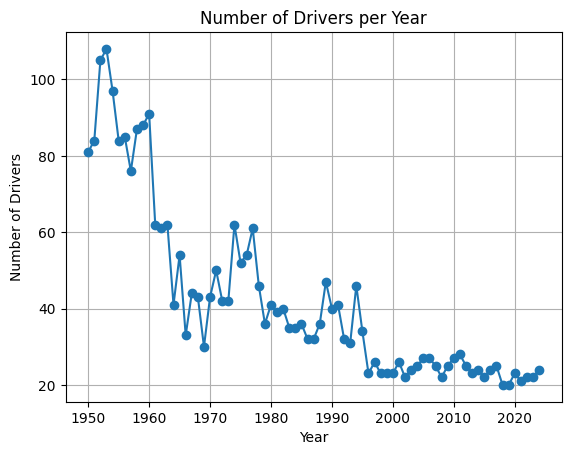

In [368]:
import matplotlib.pyplot as plt
import pandas as pd

drivers_per_year_pdf = drivers_per_year_df.toPandas()

plt.plot(drivers_per_year_pdf['year'], drivers_per_year_pdf['number_of_drivers'], marker='o', linestyle='-')
plt.title('Number of Drivers per Year')
plt.xlabel('Year')
plt.ylabel('Number of Drivers')
plt.grid(True)
plt.show()

From the above investigation we can see that it was more commcon to have more drivers and thus more positions in the overall standings. The number of drivers has beend declining very early on. These value seems plausible in the connection with the other parts of the dataset.

We want to create a new parquet file with the modifications we made.

In [371]:
driver_standings_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_driver_standings.parquet")

# Drivers

In [372]:
drivers_df = spark.read.parquet(f"/f1/data/drivers.parquet")

In [373]:
drivers_df.printSchema()

root
 |-- driverId: integer (nullable = true)
 |-- driverRef: string (nullable = true)
 |-- number: string (nullable = true)
 |-- code: string (nullable = true)
 |-- forename: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)



We don't need the url.

In [374]:
drivers_df = drivers_df.drop("url")
drivers_df.printSchema()

root
 |-- driverId: integer (nullable = true)
 |-- driverRef: string (nullable = true)
 |-- number: string (nullable = true)
 |-- code: string (nullable = true)
 |-- forename: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- nationality: string (nullable = true)



In [375]:
drivers_df.count()

861

In [376]:
drivers_df.show(5)

+--------+----------+------+----+--------+----------+----------+-----------+
|driverId| driverRef|number|code|forename|   surname|       dob|nationality|
+--------+----------+------+----+--------+----------+----------+-----------+
|       1|  hamilton|    44| HAM|   Lewis|  Hamilton|1985-01-07|    British|
|       2|  heidfeld|    \N| HEI|    Nick|  Heidfeld|1977-05-10|     German|
|       3|   rosberg|     6| ROS|    Nico|   Rosberg|1985-06-27|     German|
|       4|    alonso|    14| ALO|Fernando|    Alonso|1981-07-29|    Spanish|
|       5|kovalainen|    \N| KOV|  Heikki|Kovalainen|1981-10-19|    Finnish|
+--------+----------+------+----+--------+----------+----------+-----------+
only showing top 5 rows



In [379]:
has_nulls(drivers_df)

False


In [380]:
has_duplicates(drivers_df)

False

We want to create a new parquet file with the modifications we made.

In [381]:
drivers_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_drivers.parquet")

# Lap Times

In [382]:
lap_times_df = spark.read.parquet(f"/f1/data/lap_times.parquet")

In [384]:
lap_times_df.printSchema()
# Likely won't need both times

root
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- lap: integer (nullable = true)
 |-- position: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: integer (nullable = true)



In [385]:
lap_times_df.count()

589081

In [386]:
lap_times_df.show(5)

+------+--------+---+--------+--------+------------+
|raceId|driverId|lap|position|    time|milliseconds|
+------+--------+---+--------+--------+------------+
|    89|      31| 23|      13|2:37.615|      157615|
|    89|      31| 24|      18|2:56.340|      176340|
|    89|      35|  1|      15|1:48.789|      108789|
|    89|      35|  2|      15|1:39.573|       99573|
|    89|      35|  3|      15|1:38.462|       98462|
+------+--------+---+--------+--------+------------+
only showing top 5 rows



In [387]:
lap_times_df.describe("position").show()

+-------+-----------------+
|summary|         position|
+-------+-----------------+
|  count|           589081|
|   mean|9.661951412454314|
| stddev|5.528553215741692|
|    min|                1|
|    max|               24|
+-------+-----------------+



In [393]:
lap_times_df.describe("milliseconds").show()
lap_times_df.describe("time").show()

+-------+-----------------+
|summary|     milliseconds|
+-------+-----------------+
|  count|           589081|
|   mean|95799.44524267461|
| stddev|76399.72995510594|
|    min|            55404|
|    max|          7507547|
+-------+-----------------+

+-------+--------+
|summary|    time|
+-------+--------+
|  count|  589081|
|   mean|    NULL|
| stddev|    NULL|
|    min|0:55.404|
|    max|9:45.712|
+-------+--------+



In [394]:
has_nulls(lap_times_df)

False


In [395]:
has_duplicates(lap_times_df)

False

We want to create a new parquet file with the modifications we made.

In [396]:
lap_times_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_lap_times.parquet")

# Pit Stops

In [8]:
pit_stops_df = spark.read.parquet(f"/f1/data/pit_stops.parquet")

In [9]:
pit_stops_df.printSchema()

root
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- stop: integer (nullable = true)
 |-- lap: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- duration: string (nullable = true)
 |-- milliseconds: integer (nullable = true)



In [10]:
pit_stops_df.count()

11371

In [11]:
pit_stops_df.show(5)

+------+--------+----+---+-------------------+--------+------------+
|raceId|driverId|stop|lap|               time|duration|milliseconds|
+------+--------+----+---+-------------------+--------+------------+
|   841|     153|   1|  1|2025-04-27 17:05:23|  26.898|       26898|
|   841|      30|   1|  1|2025-04-27 17:05:52|  25.021|       25021|
|   841|      17|   1| 11|2025-04-27 17:20:48|  23.426|       23426|
|   841|       4|   1| 12|2025-04-27 17:22:34|  23.251|       23251|
|   841|      13|   1| 13|2025-04-27 17:24:10|  23.842|       23842|
+------+--------+----+---+-------------------+--------+------------+
only showing top 5 rows



In [15]:
has_nulls(pit_stops_df)

False


In [16]:
has_duplicates(pit_stops_df)

False

In [17]:
pit_stops_df.describe("lap").show()
pit_stops_df.describe("stop").show()

+-------+------------------+
|summary|               lap|
+-------+------------------+
|  count|             11371|
|   mean| 25.38738897194618|
| stddev|14.831497277230124|
|    min|                 1|
|    max|                78|
+-------+------------------+

+-------+------------------+
|summary|              stop|
+-------+------------------+
|  count|             11371|
|   mean|1.7879693958315013|
| stddev|1.5214616581601763|
|    min|                 1|
|    max|                70|
+-------+------------------+



## Stop values

The value for the highest stop seems very unlikely. Let's investigate.

In [18]:
pit_stops_df.where(pit_stops_df.stop > 10).show()

+------+--------+----+---+-------------------+--------+------------+
|raceId|driverId|stop|lap|               time|duration|milliseconds|
+------+--------+----+---+-------------------+--------+------------+
|  1128|     822|  15|  2|2025-04-27 16:04:57|  24.239|       24239|
|  1128|     840|  42|  2|2025-04-27 16:41:05|  24.132|       24132|
|  1128|     840|  48|  3|2025-04-27 16:49:27|  28.211|       28211|
|  1128|       1|  51|  2|2025-04-27 16:52:10|  24.232|       24232|
|  1128|     830|  52|  2|2025-04-27 16:53:26|  23.813|       23813|
|  1128|     858|  57|  2|2025-04-27 17:01:43|  24.384|       24384|
|  1128|     855|  70|  2|2025-04-27 17:19:04|  24.367|       24367|
+------+--------+----+---+-------------------+--------+------------+



In [19]:
races_df = spark.read.parquet(f"/f1/data/races.parquet")
races_df.join(pit_stops_df, 
               races_df.raceId == pit_stops_df.raceId, 
               "inner").where(pit_stops_df.stop > 10).select(pit_stops_df.lap, pit_stops_df.stop, pit_stops_df.driverId, races_df.name, races_df.date).show()

+---+----+--------+-----------------+----------+
|lap|stop|driverId|             name|      date|
+---+----+--------+-----------------+----------+
|  2|  15|     822|Monaco Grand Prix|2024-05-26|
|  2|  42|     840|Monaco Grand Prix|2024-05-26|
|  3|  48|     840|Monaco Grand Prix|2024-05-26|
|  2|  51|       1|Monaco Grand Prix|2024-05-26|
|  2|  52|     830|Monaco Grand Prix|2024-05-26|
|  2|  57|     858|Monaco Grand Prix|2024-05-26|
|  2|  70|     855|Monaco Grand Prix|2024-05-26|
+---+----+--------+-----------------+----------+



In [20]:
races_df.join(pit_stops_df, 
               races_df.raceId == pit_stops_df.raceId, 
               "inner").where((races_df.raceId == 1128) & (pit_stops_df.driverId == 1)).select(pit_stops_df.lap, pit_stops_df.stop, pit_stops_df.driverId, races_df.name, races_df.date).show()

+---+----+--------+-----------------+----------+
|lap|stop|driverId|             name|      date|
+---+----+--------+-----------------+----------+
|  1|   1|       1|Monaco Grand Prix|2024-05-26|
|  2|  51|       1|Monaco Grand Prix|2024-05-26|
+---+----+--------+-----------------+----------+



Based on the two queries above it seems like the stop and the lap value should be switched. All of the pitstops can be seen here: https://www.formula1.com/en/results/2024/races/1236/monaco/pit-stop-summary

All entries for this specifc race will be investigated and corrected where necessary with the following steps:
1. Count the amount of stops in lap 1, this should be 16.
2. Check all stops above 1, as these might not be correct.
3. Find the threshold of stop where the values were mixed up and swap the values.

In [21]:
races_df.join(pit_stops_df, 
               races_df.raceId == pit_stops_df.raceId, 
               "inner").where((races_df.raceId == 1128) & (pit_stops_df.stop == 1)).select(pit_stops_df.lap, pit_stops_df.stop, pit_stops_df.driverId, races_df.name, races_df.date).count()


16

In [22]:
races_df.join(pit_stops_df, 
               races_df.raceId == pit_stops_df.raceId, 
               "inner").where((races_df.raceId == 1128) & (pit_stops_df.stop > 1)).select(pit_stops_df.lap, pit_stops_df.stop, pit_stops_df.driverId, races_df.name, races_df.date).show()

+---+----+--------+-----------------+----------+
|lap|stop|driverId|             name|      date|
+---+----+--------+-----------------+----------+
|  2|  15|     822|Monaco Grand Prix|2024-05-26|
|  2|  42|     840|Monaco Grand Prix|2024-05-26|
|  3|  48|     840|Monaco Grand Prix|2024-05-26|
|  2|  51|       1|Monaco Grand Prix|2024-05-26|
|  2|  52|     830|Monaco Grand Prix|2024-05-26|
|  2|  57|     858|Monaco Grand Prix|2024-05-26|
|  2|  70|     855|Monaco Grand Prix|2024-05-26|
+---+----+--------+-----------------+----------+



In [23]:
from pyspark.sql.functions import *

columns = [e for e in pit_stops_df.columns if e not in ["stop", "lap"]]

pit_stops_above_1_df = pit_stops_df.filter((pit_stops_df.stop > 1)&(pit_stops_df.raceId == 1128)).select(
    *columns,
    col("lap").alias("stop"),
    col("stop").alias("lap")
)
pit_stops_df = pit_stops_df.filter((pit_stops_df.stop == 1) & (pit_stops_df.raceId == 1128) | (pit_stops_df.raceId != 1128)).select(
    *columns,
    "stop",
    "lap"
)

pit_stops_df = pit_stops_df.union(pit_stops_above_1_df)
pit_stops_df.where(pit_stops_df.raceId == 1128).sort("stop", ascending=False).show()

+------+--------+-------------------+---------+------------+----+---+
|raceId|driverId|               time| duration|milliseconds|stop|lap|
+------+--------+-------------------+---------+------------+----+---+
|  1128|     840|2025-04-27 16:49:27|   28.211|       28211|   3| 48|
|  1128|     822|2025-04-27 16:04:57|   24.239|       24239|   2| 15|
|  1128|     840|2025-04-27 16:41:05|   24.132|       24132|   2| 42|
|  1128|       1|2025-04-27 16:52:10|   24.232|       24232|   2| 51|
|  1128|     830|2025-04-27 16:53:26|   23.813|       23813|   2| 52|
|  1128|     858|2025-04-27 17:01:43|   24.384|       24384|   2| 57|
|  1128|     855|2025-04-27 17:19:04|   24.367|       24367|   2| 70|
|  1128|     844|2025-04-27 15:04:50|39:18.026|     2358026|   1|  1|
|  1128|     857|2025-04-27 15:04:52|39:17.645|     2357645|   1|  1|
|  1128|     846|2025-04-27 15:04:54|39:25.538|     2365538|   1|  1|
|  1128|     847|2025-04-27 15:04:56|39:29.363|     2369363|   1|  1|
|  1128|     830|202

In [24]:
pit_stops_df.describe("stop").show()

+-------+------------------+
|summary|              stop|
+-------+------------------+
|  count|             11371|
|   mean| 1.759827631694662|
| stddev|0.9256003904836632|
|    min|                 1|
|    max|                 7|
+-------+------------------+



In [70]:
pit_stops_df.count()

11371

## Pit stop duration

Let's investigate the values for the pitstop durations using the milliseconds column.

Outliers should be removed. A pit stop can take a long time due to penalties or other issues but in this part only the pitstops under normal conditions interest us. First let's figure out what outliers are and how the values changed over the years.

In [28]:
from pyspark.sql.functions import stddev, abs, count, col
from pyspark.sql.window import Window

threshold = 3

window_spec = Window.partitionBy("raceId")

df_with_stats = pit_stops_df.withColumn("mean_ms", avg("milliseconds").over(window_spec)) \
                   .withColumn("stddev_ms", stddev("milliseconds").over(window_spec))

df_with_zscore = df_with_stats.withColumn(
    "z_score", abs((col("milliseconds") - col("mean_ms")) / col("stddev_ms"))
)

outlier_counts = df_with_zscore.filter(col("z_score") > threshold) \
                               .groupBy("raceId") \
                               .agg(count("*").alias("outlier_count"))

non_outlier_counts = df_with_zscore.filter(col("z_score") <= threshold) \
                                   .groupBy("raceId") \
                                   .agg(count("*").alias("non_outlier_count"))

outlier_summary_df = outlier_counts.join(non_outlier_counts, "raceId", "fullouter") \
                                   .fillna(0) \
                                   .orderBy("raceId")

outlier_summary_df.sort("outlier_count", ascending=False).show(5)

+------+-------------+-----------------+
|raceId|outlier_count|non_outlier_count|
+------+-------------+-----------------+
|   864|            3|               64|
|   958|            3|               42|
|   881|            3|               70|
|   886|            3|               41|
|   911|            3|               43|
+------+-------------+-----------------+
only showing top 5 rows



In [33]:
window_spec = Window.partitionBy("raceId")

df_with_stats = pit_stops_df.withColumn("mean_ms", avg("milliseconds").over(window_spec)) \
                   .withColumn("stddev_ms", stddev("milliseconds").over(window_spec))

df_with_zscore = df_with_stats.withColumn(
    "z_score", abs((col("milliseconds") - col("mean_ms")) / col("stddev_ms"))
)


pit_stops_without_outliers_df = df_with_zscore.filter(col("z_score") <= threshold).drop("mean_ms", "stddev_ms", "z_score")
pit_stops_without_outliers_df.show(5)

+------+--------+-------------------+--------+------------+----+---+
|raceId|driverId|               time|duration|milliseconds|stop|lap|
+------+--------+-------------------+--------+------------+----+---+
|   841|     153|2025-04-27 17:05:23|  26.898|       26898|   1|  1|
|   841|      30|2025-04-27 17:05:52|  25.021|       25021|   1|  1|
|   841|      17|2025-04-27 17:20:48|  23.426|       23426|   1| 11|
|   841|       4|2025-04-27 17:22:34|  23.251|       23251|   1| 12|
|   841|      13|2025-04-27 17:24:10|  23.842|       23842|   1| 13|
+------+--------+-------------------+--------+------------+----+---+
only showing top 5 rows



In [245]:
pit_stops_without_outliers_df.describe("milliseconds").show()

+-------+-----------------+
|summary|     milliseconds|
+-------+-----------------+
|  count|            11094|
|   mean|85957.24445646295|
| stddev|313160.7527590613|
|    min|            12897|
|    max|          3069017|
+-------+-----------------+



These max values seem impossible.

First we check if there is possibly just one weird value.

In [34]:
pit_stops_without_outliers_df.filter(pit_stops_without_outliers_df.milliseconds != 3069017).describe("milliseconds").show()

+-------+-----------------+
|summary|     milliseconds|
+-------+-----------------+
|  count|            11093|
|   mean|85688.33074912107|
| stddev|311891.2763204656|
|    min|            12897|
|    max|          3067301|
+-------+-----------------+



There seem to be several values that are very high. Let's have a look at them.

In [35]:
pit_stops_without_outliers_df.filter(pit_stops_without_outliers_df.milliseconds == 3067301).show()
pit_stops_without_outliers_df.filter(pit_stops_without_outliers_df.milliseconds == 3069017).show()

+------+--------+-------------------+---------+------------+----+---+
|raceId|driverId|               time| duration|milliseconds|stop|lap|
+------+--------+-------------------+---------+------------+----+---+
|  1083|      20|2025-04-27 15:06:00|51:07.301|     3067301|   1|  1|
+------+--------+-------------------+---------+------------+----+---+

+------+--------+-------------------+---------+------------+----+---+
|raceId|driverId|               time| duration|milliseconds|stop|lap|
+------+--------+-------------------+---------+------------+----+---+
|  1083|     840|2025-04-27 15:06:02|51:09.017|     3069017|   1|  1|
+------+--------+-------------------+---------+------------+----+---+



In [36]:
races_df.filter(races_df.raceId == 1083).show()

+------+----+-----+---------+------------------+----------+--------+--------------------+----------+--------+----------+--------+----------+--------+----------+----------+-----------+-----------+
|raceId|year|round|circuitId|              name|      date|    time|                 url|  fp1_date|fp1_time|  fp2_date|fp2_time|  fp3_date|fp3_time|quali_date|quali_time|sprint_date|sprint_time|
+------+----+-----+---------+------------------+----------+--------+--------------------+----------+--------+----------+--------+----------+--------+----------+----------+-----------+-----------+
|  1083|2022|   10|        9|British Grand Prix|2022-07-03|14:00:00|http://en.wikiped...|2022-07-01|12:00:00|2022-07-01|15:00:00|2022-07-02|11:00:00|2022-07-02|  14:00:00|         \N|         \N|
+------+----+-----+---------+------------------+----------+--------+--------------------+----------+--------+----------+--------+----------+--------+----------+----------+-----------+-----------+



In [37]:
pit_stops_without_outliers_df.filter(pit_stops_without_outliers_df.raceId == 1083).show()

+------+--------+-------------------+---------+------------+----+---+
|raceId|driverId|               time| duration|milliseconds|stop|lap|
+------+--------+-------------------+---------+------------+----+---+
|  1083|     830|2025-04-27 15:05:31|50:37.323|     3037323|   1|  1|
|  1083|     832|2025-04-27 15:05:33|50:31.752|     3031752|   1|  1|
|  1083|       1|2025-04-27 15:05:36|50:46.888|     3046888|   1|  1|
|  1083|     844|2025-04-27 15:05:37|50:36.360|     3036360|   1|  1|
|  1083|       4|2025-04-27 15:05:41|50:55.700|     3055700|   1|  1|
|  1083|     815|2025-04-27 15:05:43|50:34.772|     3034772|   1|  1|
|  1083|     846|2025-04-27 15:05:46|50:43.215|     3043215|   1|  1|
|  1083|     849|2025-04-27 15:05:48|50:51.904|     3051904|   1|  1|
|  1083|     822|2025-04-27 15:05:50|50:55.732|     3055732|   1|  1|
|  1083|     817|2025-04-27 15:05:52|51:03.314|     3063314|   1|  1|
|  1083|     842|2025-04-27 15:05:55|50:48.950|     3048950|   1|  1|
|  1083|     825|202

Comparing these results with the results from the official site (https://www.formula1.com/en/results/2022/races/1114/great-britain/pit-stop-summary), it is visible, that both valuesets match.

These values are not interpretable for the team. Let's check how the distribution of the values is like and if we could possible just remove these values.

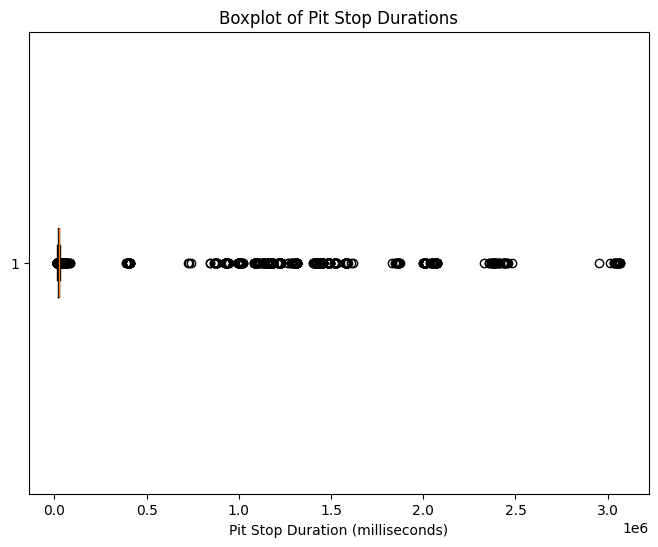

In [38]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

pit_stop_times = pit_stops_without_outliers_df.select("milliseconds").collect()
pit_stop_times_ms = [row.milliseconds for row in pit_stop_times if row.milliseconds is not None]

plt.figure(figsize=(8, 6))
plt.boxplot(pit_stop_times_ms, vert=False)
plt.xlabel("Pit Stop Duration (milliseconds)")
plt.title("Boxplot of Pit Stop Durations")
plt.show()


A full pitstop (including entering and exiting the pitlane) usually takes somewhere between 20 and 25 seconds. Using the boxplot to create a cutoff, it seems like all values that are in or above the cluster at around 500000ms (=500s) seem to be wrong values.

As there is quite thegab between the 'normal' values and the wrong values, the cutoff will be set to 300000.

In [39]:
pit_stops_without_outliers_big_df = pit_stops_without_outliers_df.filter(pit_stops_without_outliers_df.milliseconds > 300000)
pit_stops_without_outliers_big_df.describe("milliseconds").show()

pit_stops_without_outliers_small_df = pit_stops_without_outliers_df.filter(pit_stops_without_outliers_df.milliseconds < 300000)
pit_stops_without_outliers_small_df.describe("milliseconds").show()

+-------+------------------+
|summary|      milliseconds|
+-------+------------------+
|  count|               475|
|   mean|1465743.5031578948|
| stddev| 549111.0949440326|
|    min|            387399|
|    max|           3069017|
+-------+------------------+

+-------+------------------+
|summary|      milliseconds|
+-------+------------------+
|  count|             10619|
|   mean|24237.828985780205|
| stddev| 4385.253734099694|
|    min|             12897|
|    max|             87084|
+-------+------------------+



In [40]:
pit_stops_without_outliers_big_df.count()

475

In [41]:
pit_stops_without_outliers_small_df.count()

10619

Eventhough it is definitely not ideal, the values above 300'000 are in a clear minority and will be removed for this project. In a real scenario this would have to be investigated further to find a possible pattern in the values that are missing and act accordingly.

In [42]:
pit_stops_df = pit_stops_without_outliers_small_df

We want to create a new parquet file with the modifications we made.

In [43]:
pit_stops_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_pit_stops.parquet")

# Qualifying

In [507]:
qualifying_df = spark.read.parquet(f"/f1/data/qualifying.parquet")

In [508]:
qualifying_df.printSchema()

root
 |-- qualifyId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- number: integer (nullable = true)
 |-- position: integer (nullable = true)
 |-- q1: string (nullable = true)
 |-- q2: string (nullable = true)
 |-- q3: string (nullable = true)



The number of the driver is redundant as there is the driverId as well.

In [509]:
qualifying_df = qualifying_df.drop("number")
qualifying_df.printSchema()

root
 |-- qualifyId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- position: integer (nullable = true)
 |-- q1: string (nullable = true)
 |-- q2: string (nullable = true)
 |-- q3: string (nullable = true)



In [510]:
qualifying_df.count()

10494

In [511]:
qualifying_df.show(5)

+---------+------+--------+-------------+--------+--------+--------+--------+
|qualifyId|raceId|driverId|constructorId|position|      q1|      q2|      q3|
+---------+------+--------+-------------+--------+--------+--------+--------+
|        1|    18|       1|            1|       1|1:26.572|1:25.187|1:26.714|
|        2|    18|       9|            2|       2|1:26.103|1:25.315|1:26.869|
|        3|    18|       5|            1|       3|1:25.664|1:25.452|1:27.079|
|        4|    18|      13|            6|       4|1:25.994|1:25.691|1:27.178|
|        5|    18|       2|            2|       5|1:25.960|1:25.518|1:27.236|
+---------+------+--------+-------------+--------+--------+--------+--------+
only showing top 5 rows



In [512]:
qualifying_df.describe("position").show()

+-------+------------------+
|summary|          position|
+-------+------------------+
|  count|             10494|
|   mean|11.195826186392225|
| stddev|6.2603736624803785|
|    min|                 1|
|    max|                28|
+-------+------------------+



Since the highest position is only 28 it seems like the qualifying has not been done since the start. Let's double check.

In [513]:
races_df = spark.read.parquet(f"/f1/data/races.parquet")
joined_races = races_df.join(qualifying_df, 
               races_df.raceId == qualifying_df.raceId, 
               "inner").orderBy(races_df.year, ascending=True).select(races_df.year, races_df.raceId)
joined_races.show(1)

+----+------+
|year|raceId|
+----+------+
|1994|   257|
+----+------+
only showing top 1 row



In [516]:
qualifying_df.filter(qualifying_df.position == 28).show()

+---------+------+--------+-------------+--------+---+---+---+
|qualifyId|raceId|driverId|constructorId|position| q1| q2| q3|
+---------+------+--------+-------------+--------+---+---+---+
|     2673|   259|      22|           17|      28| \N| \N| \N|
+---------+------+--------+-------------+--------+---+---+---+



In [518]:
qualifying_df.filter(qualifying_df.raceId == 259) \
    .agg(countDistinct("driverId").alias("number_of_drivers")).show()

+-----------------+
|number_of_drivers|
+-----------------+
|               28|
+-----------------+



In [444]:
from pyspark.sql.functions import count

qualifying_df.groupBy("position").agg(count("*").alias("count")).orderBy("count", ascending=True).show(10)

+--------+-----+
|position|count|
+--------+-----+
|      28|    1|
|      27|    1|
|      26|   20|
|      25|   20|
|      24|   82|
|      23|   90|
|      22|  207|
|      21|  215|
|      20|  479|
|      19|  487|
+--------+-----+
only showing top 10 rows



In [445]:
has_nulls(qualifying_df)

Column 'q2' has 22 null value(s):
+---------+------+--------+-------------+--------+--------+----+----+
|qualifyId|raceId|driverId|constructorId|position|      q1|  q2|  q3|
+---------+------+--------+-------------+--------+--------+----+----+
|    10068|  1120|     832|            6|      16|1:24.738|NULL|NULL|
|    10069|  1120|     825|          210|      17|1:24.764|NULL|NULL|
|    10070|  1120|     822|           51|      18|1:24.788|NULL|NULL|
|    10071|  1120|     855|           51|      19|1:25.159|NULL|NULL|
|    10107|  1122|     807|          210|      15|1:29.055|NULL|NULL|
|    10108|  1122|     822|           15|      16|1:29.179|NULL|NULL|
|    10109|  1122|     839|          214|      17|1:29.475|NULL|NULL|
|    10110|  1122|     842|          214|      18|1:29.479|NULL|NULL|
|    10111|  1122|     858|            3|      19|1:29.526|NULL|NULL|
|    10207|  1127|     822|           15|      16|1:16.626|NULL|NULL|
|    10208|  1127|     855|           15|      17|1:16.8

In [446]:
has_duplicates(qualifying_df)

False

We want to create a new parquet file with the modifications we made.

In [447]:
qualifying_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_qualifying.parquet")

# Races

In [449]:
races_df = spark.read.parquet(f"/f1/data/races.parquet")

In [450]:
races_df.printSchema()

root
 |-- raceId: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- round: integer (nullable = true)
 |-- circuitId: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- url: string (nullable = true)
 |-- fp1_date: string (nullable = true)
 |-- fp1_time: string (nullable = true)
 |-- fp2_date: string (nullable = true)
 |-- fp2_time: string (nullable = true)
 |-- fp3_date: string (nullable = true)
 |-- fp3_time: string (nullable = true)
 |-- quali_date: string (nullable = true)
 |-- quali_time: string (nullable = true)
 |-- sprint_date: string (nullable = true)
 |-- sprint_time: string (nullable = true)



In [451]:
races_df = races_df.drop("url")
races_df.printSchema()
# will likely be able to remove A LOT

root
 |-- raceId: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- round: integer (nullable = true)
 |-- circuitId: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- fp1_date: string (nullable = true)
 |-- fp1_time: string (nullable = true)
 |-- fp2_date: string (nullable = true)
 |-- fp2_time: string (nullable = true)
 |-- fp3_date: string (nullable = true)
 |-- fp3_time: string (nullable = true)
 |-- quali_date: string (nullable = true)
 |-- quali_time: string (nullable = true)
 |-- sprint_date: string (nullable = true)
 |-- sprint_time: string (nullable = true)



In [452]:
races_df.count()

1125

In [453]:
races_df.show(5)

+------+----+-----+---------+--------------------+----------+--------+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|raceId|year|round|circuitId|                name|      date|    time|fp1_date|fp1_time|fp2_date|fp2_time|fp3_date|fp3_time|quali_date|quali_time|sprint_date|sprint_time|
+------+----+-----+---------+--------------------+----------+--------+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|     1|2009|    1|        1|Australian Grand ...|2009-03-29|06:00:00|      \N|      \N|      \N|      \N|      \N|      \N|        \N|        \N|         \N|         \N|
|     2|2009|    2|        2|Malaysian Grand Prix|2009-04-05|09:00:00|      \N|      \N|      \N|      \N|      \N|      \N|        \N|        \N|         \N|         \N|
|     3|2009|    3|       17|  Chinese Grand Prix|2009-04-19|07:00:00|      \N|      \N|      \N|      \N|      \N|      \N|        \N|        \N

In [454]:
races_df.describe("round").show() # order of races in a season

+-------+-----------------+
|summary|            round|
+-------+-----------------+
|  count|             1125|
|   mean|8.579555555555556|
| stddev| 5.15990994308997|
|    min|                1|
|    max|               24|
+-------+-----------------+



In [455]:
has_nulls(races_df)

False


In [456]:
has_duplicates(races_df)

False

We want to create a new parquet file with the modifications we made.

In [457]:
races_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_races.parquet")

# Results

In [458]:
results_df = spark.read.parquet(f"/f1/data/results.parquet")

In [459]:
results_df.printSchema()

root
 |-- resultId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- number: string (nullable = true)
 |-- grid: integer (nullable = true)
 |-- position: string (nullable = true)
 |-- positionText: string (nullable = true)
 |-- positionOrder: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- laps: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: string (nullable = true)
 |-- fastestLap: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- fastestLapTime: string (nullable = true)
 |-- fastestLapSpeed: string (nullable = true)
 |-- statusId: integer (nullable = true)



In [462]:
results_df.count()

26759

In [463]:
results_df.show(5)

+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|resultId|raceId|driverId|constructorId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|
+--------+------+--------+-------------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+
|       1|    18|       1|            1|    22|   1|       1|           1|            1|  10.0|  58|1:34:50.616|     5690616|        39|   2|      1:27.452|        218.300|       1|
|       2|    18|       2|            2|     3|   5|       2|           2|            2|   8.0|  58|     +5.478|     5696094|        41|   3|      1:27.739|        217.586|       1|
|       3|    18|       3|            3|     7|   7|       3|           3|            3|  

In [464]:
results_df.describe("points").show()
results_df.describe("positionOrder").show()

+-------+------------------+
|summary|            points|
+-------+------------------+
|  count|             26759|
|   mean|1.9876321985126502|
| stddev| 4.351208910645779|
|    min|               0.0|
|    max|              50.0|
+-------+------------------+

+-------+------------------+
|summary|     positionOrder|
+-------+------------------+
|  count|             26759|
|   mean|12.794050599798199|
| stddev|7.6659506386904255|
|    min|                 1|
|    max|                39|
+-------+------------------+



In [476]:
from pyspark.sql.functions import count

# nowadays first gets 25 points
results_df.groupBy("points").agg(count("*").alias("count")).orderBy("points", ascending=True).show(5)
results_df.groupBy("points").agg(count("*").alias("count")).orderBy("points", ascending=False).show(5)

+------+-----+
|points|count|
+------+-----+
|   0.0|18589|
|   0.5|    6|
|   1.0| 1066|
|  1.33|    3|
|   1.5|   17|
+------+-----+
only showing top 5 rows

+------+-----+
|points|count|
+------+-----+
|  50.0|    1|
|  36.0|    1|
|  30.0|    1|
|  26.0|   37|
|  25.0|  266|
+------+-----+
only showing top 5 rows



In [474]:
results_df.groupBy("statusId").agg(count("*").alias("count")).orderBy("count", ascending=False).show(5)


+--------+-----+
|statusId|count|
+--------+-----+
|       1| 7674|
|      11| 4037|
|       5| 2026|
|      12| 1613|
|       3| 1062|
+--------+-----+
only showing top 5 rows



In [470]:
has_nulls(results_df)

False


In [471]:
has_duplicates(results_df)

False

We want to create a new parquet file with the modifications we made.

In [477]:
results_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_results.parquet")

# Season

In [478]:
season_df = spark.read.parquet(f"/f1/data/seasons.parquet")

In [479]:
season_df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- url: string (nullable = true)



In [481]:
season_df = season_df.drop("url")
season_df.printSchema()

root
 |-- year: integer (nullable = true)



In [482]:
season_df.count()

75

In [483]:
season_df.show(5)

+----+
|year|
+----+
|2009|
|2008|
|2007|
|2006|
|2005|
+----+
only showing top 5 rows



In [484]:
season_df.describe("year").show()

+-------+-----------------+
|summary|             year|
+-------+-----------------+
|  count|               75|
|   mean|           1987.0|
| stddev|21.79449471770337|
|    min|             1950|
|    max|             2024|
+-------+-----------------+



In [485]:
from pyspark.sql.functions import count

season_df.groupBy("year").agg(count("*").alias("count")).orderBy("count", ascending=False).show(5)

+----+-----+
|year|count|
+----+-----+
|1959|    1|
|1990|    1|
|1975|    1|
|1977|    1|
|2003|    1|
+----+-----+
only showing top 5 rows



In [486]:
has_nulls(season_df)

False


In [487]:
has_duplicates(season_df)

False

We want to create a new parquet file with the modifications we made.

In [488]:
season_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_seasons.parquet")

# Sprint Results

In [489]:
sprint_results_df = spark.read.parquet(f"/f1/data/sprint_results.parquet")

In [490]:
sprint_results_df.printSchema()

root
 |-- resultId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- number: integer (nullable = true)
 |-- grid: integer (nullable = true)
 |-- position: string (nullable = true)
 |-- positionText: string (nullable = true)
 |-- positionOrder: integer (nullable = true)
 |-- points: integer (nullable = true)
 |-- laps: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: string (nullable = true)
 |-- fastestLap: string (nullable = true)
 |-- fastestLapTime: string (nullable = true)
 |-- statusId: integer (nullable = true)



In [491]:
sprint_results_df = sprint_results_df.drop("number", "positionText", "position")
sprint_results_df.printSchema()

root
 |-- resultId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- grid: integer (nullable = true)
 |-- positionOrder: integer (nullable = true)
 |-- points: integer (nullable = true)
 |-- laps: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: string (nullable = true)
 |-- fastestLap: string (nullable = true)
 |-- fastestLapTime: string (nullable = true)
 |-- statusId: integer (nullable = true)



In [492]:
sprint_results_df.count()

360

In [493]:
sprint_results_df.show(5)

+--------+------+--------+-------------+----+-------------+------+----+---------+------------+----------+--------------+--------+
|resultId|raceId|driverId|constructorId|grid|positionOrder|points|laps|     time|milliseconds|fastestLap|fastestLapTime|statusId|
+--------+------+--------+-------------+----+-------------+------+----+---------+------------+----------+--------------+--------+
|       1|  1061|     830|            9|   2|            1|     3|  17|25:38.426|     1538426|        14|      1:30.013|       1|
|       2|  1061|       1|          131|   1|            2|     2|  17|   +1.430|     1539856|        17|      1:29.937|       1|
|       3|  1061|     822|          131|   3|            3|     1|  17|   +7.502|     1545928|        17|      1:29.958|       1|
|       4|  1061|     844|            6|   4|            4|     0|  17|  +11.278|     1549704|        16|      1:30.163|       1|
|       5|  1061|     846|            1|   6|            5|     0|  17|  +24.111|     1562

In [494]:
sprint_results_df.describe("positionOrder").show()

+-------+-----------------+
|summary|    positionOrder|
+-------+-----------------+
|  count|              360|
|   mean|             10.5|
| stddev|5.774306744917618|
|    min|                1|
|    max|               20|
+-------+-----------------+



In [495]:
from pyspark.sql.functions import count

sprint_results_df.groupBy("raceId").agg(count("*").alias("count")).orderBy("count", ascending=False).show(5)

+------+-----+
|raceId|count|
+------+-----+
|  1084|   20|
|  1139|   20|
|  1143|   20|
|  1077|   20|
|  1065|   20|
+------+-----+
only showing top 5 rows



In [496]:
has_nulls(sprint_results_df)

False


In [497]:
has_duplicates(sprint_results_df)

False

We want to create a new parquet file with the modifications we made.

In [498]:
sprint_results_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_sprint_results.parquet")

# Status

In [499]:
status_df = spark.read.parquet(f"/f1/data/status.parquet")

In [500]:
status_df.printSchema()

root
 |-- statusId: integer (nullable = true)
 |-- status: string (nullable = true)



In [501]:
status_df.count()

139

In [502]:
status_df.show(5)

+--------+------------+
|statusId|      status|
+--------+------------+
|       1|    Finished|
|       2|Disqualified|
|       3|    Accident|
|       4|   Collision|
|       5|      Engine|
+--------+------------+
only showing top 5 rows



In [503]:
has_nulls(status_df)

False


In [504]:
has_duplicates(status_df)

False

We want to create a new parquet file with the modifications we made.

In [505]:
sprint_results_df.write.mode('overwrite').parquet(f"/f1/data/cleaned_sprint_results.parquet")